In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [2]:
limit_ListPrice = 1800
price_segment = 30
customer_traffic_segment = 0.0833 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.0416 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4

# Dynamic Pricing with Reinforcement Learning

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [22]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_training.csv")
df_val = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_validation.csv")

SİDE OTELLERİ

In [23]:
df=df.loc[df['DWHotelID'].isin([279.0, 105.0, 159.0, 50.0, 103.0, 106.0, 160.0, 98.0, 460.0, 380.0, 388.0, 389.0, 501.0, ])]
df_val =df_val.loc[df_val['DWHotelID'].isin([279.0, 105.0, 159.0, 50.0, 103.0, 106.0, 160.0, 98.0, 460.0, 380.0, 388.0, 389.0, 501.0, ])]
df = df.reset_index()


In [24]:
df = df[df['ListPriceTRY']<=limit_ListPrice]
df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
print('------------------------------------------------------------------------')
print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
print('------------------------------------------------------------------------')
print(df.shape)


------------------------------------------------------------------------
Max Purchase Amount: 1537.8 Min Purchase Amount: 183.0
Max List Price: 1797.9571428571428 Min List Price: 223.3333333333333
Max Rate: 4.5 Min Rate: 4.0
Max Feature Score: 1.6416480998083989 Min Feature Score: 1.1421555573133644
Max Room Count: 362.001 Min Room Count: 0.001
------------------------------------------------------------------------
(1123, 16)


In [25]:
df_val = df_val[df_val['ListPriceTRY']<=limit_ListPrice]
df_val = df_val[df_val['PurchaseAmountTRY']<=limit_ListPrice]
print('------------------------------------------------------------------------')
print('Max Purchase Amount:', df_val['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df_val['PurchaseAmountTRY'].min())
print('Max List Price:', df_val['ListPriceTRY'].max() , 'Min List Price:', df_val['ListPriceTRY'].min() )
print('Max Rate:', df_val['RatingTripA'].max(), 'Min Rate:',df_val['RatingTripA'].min())
print('Max Feature Score:', df_val['featureScore'].max() , 'Min Feature Score:', df_val['featureScore'].min())
print('Max Room Count:', df_val['empty_rooms'].max() , 'Min Room Count:', df_val['empty_rooms'].min())
print('------------------------------------------------------------------------')
print(df_val.shape)


------------------------------------------------------------------------
Max Purchase Amount: 1201.8363636363636 Min Purchase Amount: 773.6
Max List Price: 1741.6727272727271 Min List Price: 1028.1333333333334
Max Rate: 4.5 Min Rate: 4.0
Max Feature Score: 1.6416480998083989 Min Feature Score: 1.1421555573133644
Max Room Count: 289.001 Min Room Count: 2.001
------------------------------------------------------------------------
(10, 16)


### UTILITY FUNCTIONS

In [26]:
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(data_frame):
    
  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean Absolute Percentage Error ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
 
  return

#### Reward Functions

In [27]:
def proposed(list_price, purchase, empty_rooms):
    return (list_price-purchase)/empty_rooms
def timestamp(list_price, purchase, empty_rooms,list_price2, purchase2, empty_rooms2):
    return (list_price2-purchase2)/empty_rooms2 - (list_price-purchase)/empty_rooms
def profit(list_price,purchase):
    return (list_price-purchase)/(purchase+0.001)

#### Draw Functions

In [28]:
def draw(moving_avg, moving_avg_val, moving_avg_all, df, validation):
    print("Validation")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_val))], moving_avg_val)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    validation.reset_index()
    validation = validation[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    validation.plot.area(stacked=False);
    plt.show()
    

    print("All Dataset")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_all))],moving_avg_all)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    df2 = pd.concat([df,validation])
    df22 = df2[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    df22.plot.area(stacked=False);
    plt.show()
    print("\n\n\|")
    print_metrics(validation)
    print("|")
    print_metrics(df2)
    print("|")
    print_metrics(df)

### AGENT CLASS: SALE
 * Initializes first list price according to purchase amount
 * Takes actions: +10%, 0, -5%

In [29]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

### LOAD Q TABLE

In [30]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_30_1800_3acts.npy',allow_pickle='TRUE').item()

### RL FUNCTIONS

#### 1- RL WITH PROPOSED REWARD FUNCTION

In [31]:
def RL_proposed(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 1
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0

        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
   
            current_q = q_table[obs][action]
            
            rewardrate = proposed(agent.list_price, agent.purchase,agent.empty_rooms)
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 100:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

#### RUN RL ALGORITHMS

### DRAW AND PRINT METRICS

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


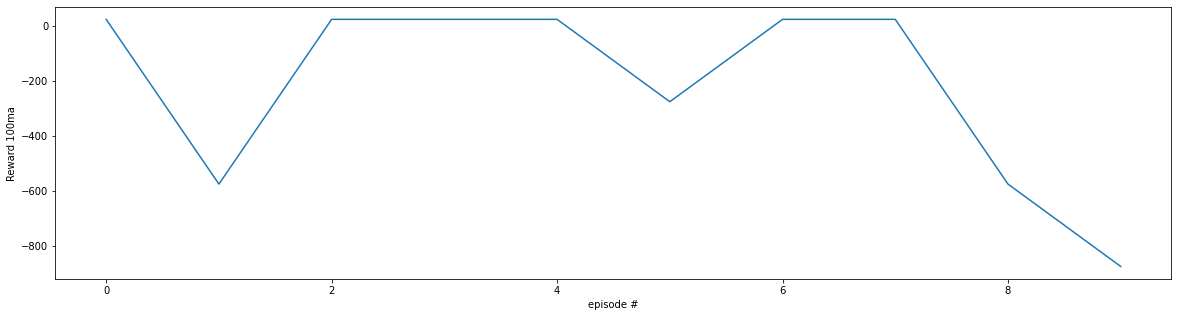

<Figure size 1440x360 with 0 Axes>

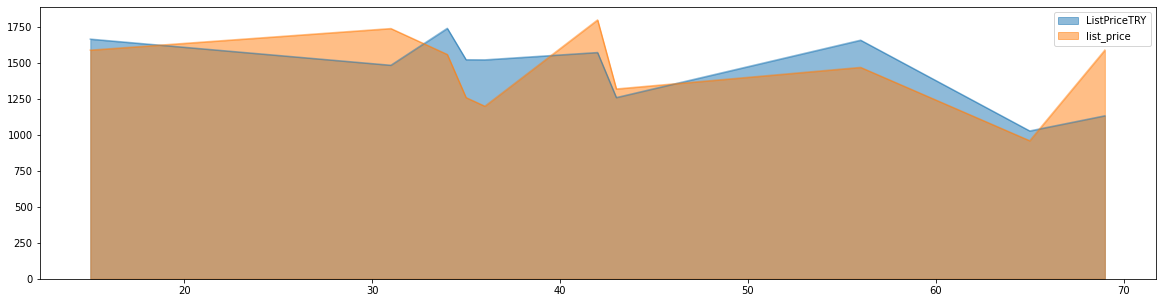

All Dataset


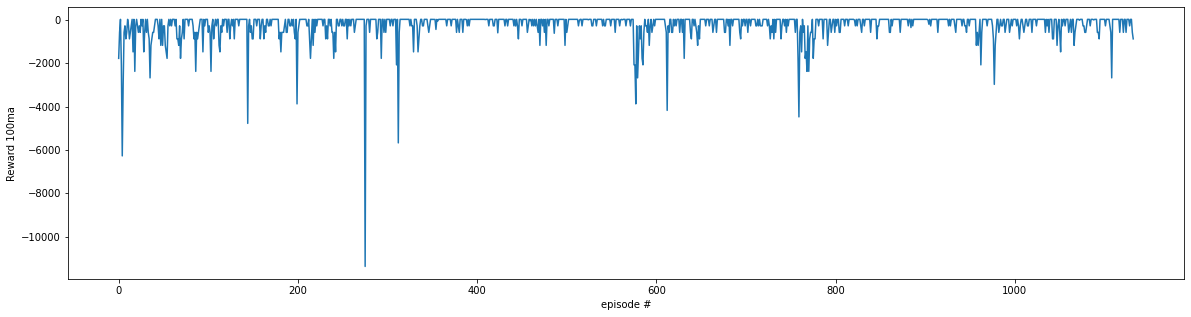

<Figure size 1440x360 with 0 Axes>

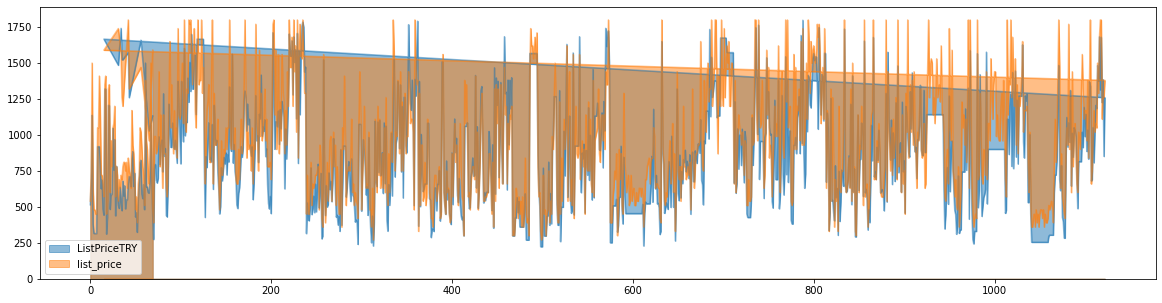



\|
*Number of Sales:  10
*Mean Absolute Error:  210.01752743283504
*Mean Absolute Percentage Error  14.818952353668749
*Mean of Recommended List Prices: 1449.0
*Mean of Original List Prices: 1459.2942235980267
*Standard Deviation of Recommended List Prices: 261.1704424317576
*Standard Deviation of Original List Prices: 239.51905906579154
|
*Number of Sales:  1133
*Mean Absolute Error:  145.16380476191293
*Mean Absolute Percentage Error  20.155094090188097
*Mean of Recommended List Prices: 952.9832303618712
*Mean of Original List Prices: 860.2330981823254
*Standard Deviation of Recommended List Prices: 385.89407529921954
*Standard Deviation of Original List Prices: 384.1697383957028
|
*Number of Sales:  1123
*Mean Absolute Error:  144.58630055291096
*Mean Absolute Percentage Error  20.202610935571176
*Mean of Recommended List Prices: 948.566340160285
*Mean of Original List Prices: 854.898626896344
*Standard Deviation of Recommended List Prices: 384.03383852648346
*Standard Deviation o

In [32]:
q_table = q_table_main.copy()
df, moving_avg_train = RL_proposed(df.shape[0], epsilon, df, q_table)

q_table2 = q_table_main.copy()
df_val, moving_avg_val = RL_proposed(df_val.shape[0], epsilon, df_val, q_table2)

moving_avg_all =[moving_avg_train, moving_avg_val]

draw(moving_avg_train, 
     moving_avg_val, 
     np.concatenate(moving_avg_all), 
     df,  
     df_val)


In [33]:
np.save('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/results/moving_avg_side.npy',moving_avg_all)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
